In [74]:
import networkx as nx
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns

In [5]:
# 1a config model

def config_model(degseq):
    G = nx.Graph()
    # creating nodes to populate G with
    n = len(degseq)
    G.add_nodes_from(range(n)) 

    # creating a list of stubs to sample from instead of the nodes
    stubs = [node for node, degree in enumerate(degseq) for _ in range(degree)]

    # handle edge case of uneven deg seq
    if len(stubs) % 2 != 0:
        print("Error: Degree sequence must sum to an even number.")
        return None

    # shuffle list to randomize pairings
    random.shuffle(stubs)

    # pair each adjacent stub
    for i in range(0, len(stubs), 2):
        u = stubs[i]
        v = stubs[i+1]
        G.add_edge(u, v)
        
    return G

In [50]:
# 1b chung lu

def chung_lu(degseq): 
    # same as before
    G = nx.Graph()
    ds_copy = list(degseq)
    N = len(ds_copy)
    G.add_nodes_from(range(N))

    for i in range(N):
        for j in range(i+1, N): # nested for loop to get all possible combos w/o visiting any twice
            ki = ds_copy[i]
            ji = ds_copy[j]
            pr = (ki*ji)/sum(ds_copy) # 2m = sum of degree sequence
            if random.random()< pr:
                G.add_edge(i, j)
    return G

In [9]:
# 1c model diff (setup)

degrees=[8,5,5,4,3,2,2,2,1,1,1,1,1,1,1]
# init lists to contain samples
config_graphs = []
cl_graphs = []

# collecting samples
for i in range(1000):
    G = config_model(degrees)
    config_graphs.append(G)

for i in range(1000):
    G = chung_lu(degrees)
    cl_graphs.append(G)

def avg_adj_matrix(sample): # function to calculate avg adjacency matrix
    n = len(degrees)
    sum_matrix = np.zeros((n, n)) # zero matrix to act as "running total"
    for g in sample:
        sum_matrix += nx.to_numpy_array(g) # convert to array and add to sum
    avg_matrix = sum_matrix / len(sample)
    return avg_matrix

config_avg_adj = avg_adj_matrix(config_graphs)
cl_avg_adj = avg_adj_matrix(cl_graphs)



In [ ]:
# 1c model diff (heatmap)
fig, ax = plt.subplots(1, 2, figsize=(12,6))

im1 = ax[0].imshow(config_avg_adj, cmap='viridis')
fig.colorbar(im1, ax=ax[0])
ax[0].set_title('default')

im2 = ax[1].imshow(cl_avg_adj, cmap='viridis')
fig.colorbar(im2, ax=ax[1])
ax[1].set_title('chung lu')

plt.tight_layout()

differences:
1. chung lu does not preserve exact deg dist (how close is approximate?)
2. edge probs are independent in chung lu
3. no multi edges/self loop in chung lu
4. default considers all possible incarnations of a network that satisfy its constraints as equally probable

metrics:
deg dist should be about same
cc diff


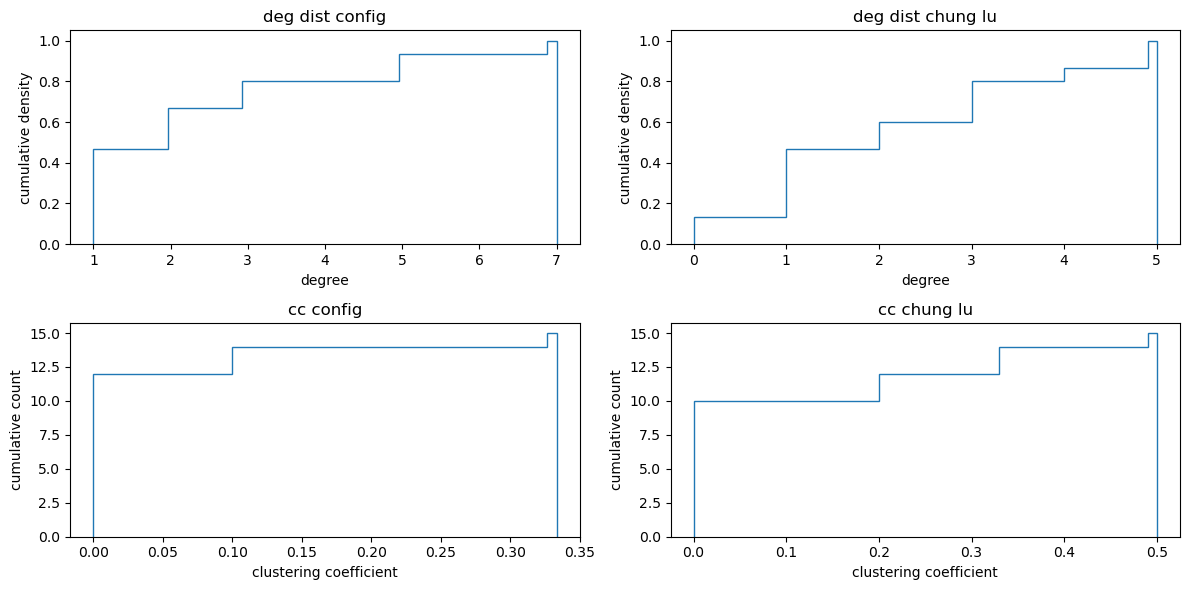

In [26]:
# 1c model diff part 2

# initial setup. creating graphs and collecting data
G_config = config_model(degrees)
G_chunglu = chung_lu(degrees)

config_degrees = [d for _, d in nx.degree(G_config)]
cl_degrees = [d for _, d in nx.degree(G_chunglu)]
config_cc = nx.clustering(G_config)
cl_cc = nx.clustering(G_chunglu)

# creating plots
fig, ax = plt.subplots(2, 2, figsize=(12,6))

# degree distribution on top row in cumulative distribution form
ax[0,0].hist(config_degrees, 
             bins=50, 
             cumulative=True, 
             density=True, 
             histtype='step')
ax[0,0].set_title('deg dist config')
ax[0,0].set_xlabel('degree')
ax[0,0].set_ylabel('cumulative density')

ax[0,1].hist(cl_degrees,
             bins=50,
             cumulative=True,
             density=True,
             histtype='step')
ax[0,1].set_title('deg dist chung lu') 
ax[0,1].set_xlabel('degree')
ax[0,1].set_ylabel('cumulative density')

# clustering coefficient on bottom
ax[1,0].hist(list(config_cc.values()),
             bins=50,
             cumulative=True,
             histtype='step')
ax[1,0].set_title('cc config')
ax[1,0].set_xlabel('clustering coefficient')
ax[1,0].set_ylabel('cumulative count')

ax[1,1].hist(list(cl_cc.values()), 
             bins=50,
             cumulative=True,
             histtype='step')
ax[1,1].set_title('cc chung lu') 
ax[1,1].set_xlabel('clustering coefficient')
ax[1,1].set_ylabel('cumulative count')

fig.tight_layout()

In [61]:
# 2a communities (setup)

G = nx.read_edgelist("C:\\Users\\User\\Documents\\network datasets\\flybrain\\bn-fly-drosophila_medulla_1.edges")

# getting largest connected component
all_components = sorted(nx.connected_components(G), key=len, reverse=True)
main = G.subgraph(all_components[0])

communities = list(nx.community.greedy_modularity_communities(main)) # finding communities
modularity = nx.community.modularity(main, communities) # calculating modularity

print(modularity)
print(len(communities))

# creating partition dict
partition = {}
for community_id, community in enumerate(communities):
    for node_id in community:
        partition[node_id] = community_id

0.37890578479208575
16


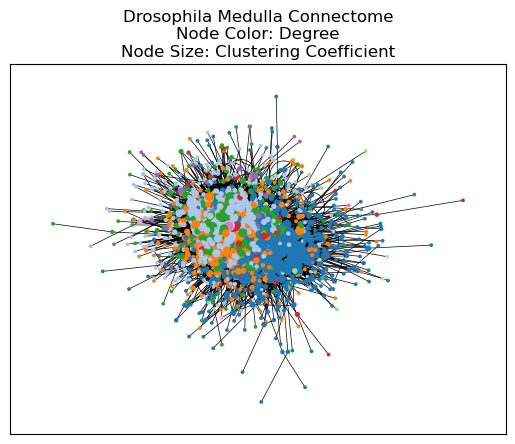

In [ ]:
# 2a communities (visualization)

color_map = [partition[node_id] for node_id in main.nodes()] # color mapping
pos = nx.spring_layout(main)
degrees = [d for _, d in main.degree()] # degrees for node sizing
nx.draw_networkx(main, 
        pos=pos,
        with_labels=False,
        node_color=color_map,
        node_size=[1 + (v * 2) for v in degrees],
        cmap=plt.cm.tab20,
        width=0.5,)

plt.title("Drosophila Medulla Connectome\nNode Color: Community\nNode Size: Degree")
plt.show()

In [60]:
# 2b null models

G_null = chung_lu([d for _, d in G.degree()])

null_communities = list(nx.community.greedy_modularity_communities(G_null))
null_modularity = nx.community.modularity(G_null, null_communities)
print(null_modularity)

null_partition = {}
for community_id, community in enumerate(null_communities):
    for node_id in community:
        null_partition[node_id] = community_id

0.23815178657521


In [ ]:
# 2c comparison

# gathering community size data
sizedict = Counter(partition.values())
sizelist = list(sizedict.values())
null_sizedict = Counter(null_partition.values())
null_sizelist = list(null_sizedict.values())

# creating plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))

ax[0].hist(sizelist, cumulative=True)
ax[0].set_xscale('log') # log scale to avoid squishing small values
ax[0].set_yscale('log')
ax[0].set_xlabel('Community Size')
ax[0].set_ylabel('Count')
ax[0].set_title('Real Network')

ax[1].hist(null_sizelist, cumulative=True)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Community Size')
ax[1].set_ylabel('Count')
ax[1].set_title('Null Model (Chung-Lu)')

# get limits
x_min_0, x_max_0 = ax[0].get_xlim()
x_min_1, x_max_1 = ax[1].get_xlim()
y_min_0, y_max_0 = ax[0].get_ylim()
y_min_1, y_max_1 = ax[1].get_ylim()

# min/max for all axes
final_x_min = min(x_min_0, x_min_1)
final_x_max = max(x_max_0, x_max_1)
final_y_min = min(y_min_0, y_min_1)
final_y_max = max(y_max_0, y_max_1)

# set limits to be the same
ax[0].set_xlim(final_x_min, final_x_max)
ax[1].set_xlim(final_x_min, final_x_max)
ax[0].set_ylim(final_y_min, final_y_max)
ax[1].set_ylim(final_y_min, final_y_max)

In [ ]:
# 3i pref attachment function

def preferentialGenerator (n, a):
    ''' 
    generates random graph with n nodes and preferential attachment parameter a
    '''
    G = nx.Graph()
    G.add_node(0)
    for i in range(n-1):
        G.add_node(i+1)
        existing_nodes = list(range(i + 1))
        denominator = sum([G.degree(m)**a + 1 for m in existing_nodes])
        for j in existing_nodes:
            numerator = G.degree(j)**a + 1
            if denominator == 0:
                p = 0
            else:
                p = numerator / denominator
            if random.random() < p:
                G.add_edge(i+1, j)
    return G

Text(0.5, 1.0, 'a=2')

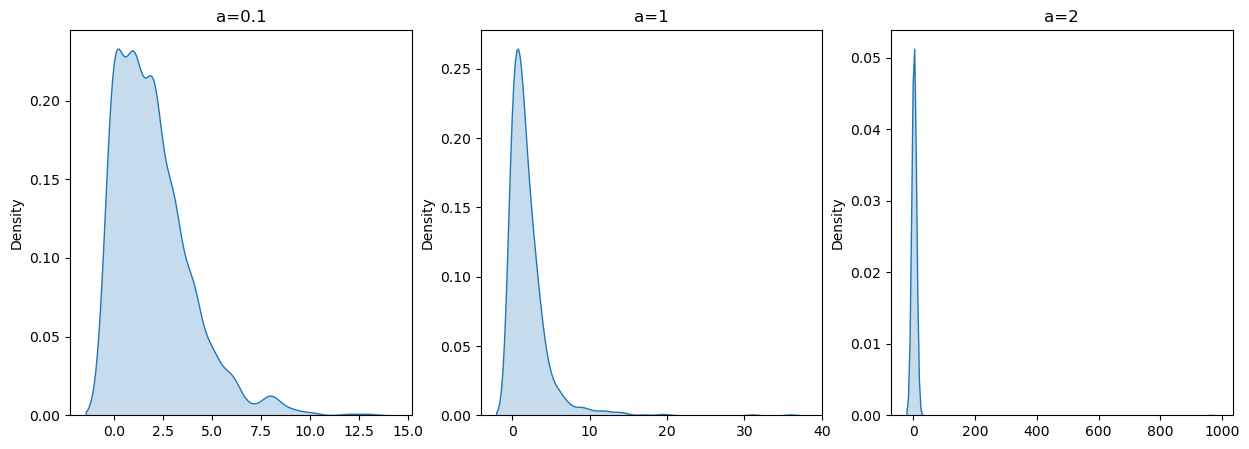

In [78]:
# 3ii degree analysis

a01 = preferentialGenerator(1000, 0.1)
a1 = preferentialGenerator(1000, 1)
a2 = preferentialGenerator(1000, 2)

fig, ax = plt.subplots(1, 3, figsize=(15,5))

sns.kdeplot([d for _, d in a01.degree()], fill=True, ax=ax[0])
sns.kdeplot([d for _, d in a1.degree()], fill=True, ax=ax[1])
sns.kdeplot([d for _, d in a2.degree()], fill=True, ax=ax[2])

ax[0].set_title('a=0.1')
ax[1].set_title('a=1')
ax[2].set_title('a=2')



In [ ]:
# 3iii pref attachment random walk

def randomWalkGenerator(n, p):
    G = nx.Graph()
    G.add_node(0)